# Compare models

In [22]:
import pickle 
import json
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
from epiweeks import Week
import properscoring as ps
from datetime import datetime
from datetime import datetime
import matplotlib.pyplot as plt 
from train_models import LOOK_BACK, PREDICT_N 
from sklearn.metrics import mean_squared_error as mse

In [23]:
PATH_LSTM = '../predictions/lstm'
PATH_PGBM = '../predictions/pgbm'

## Loading list of cities

In [24]:
df = pd.read_csv('s_cities.csv', index_col = 'Unnamed: 0')
#df = df.loc[df.geocode.isin([2112209, 2111300, 3168606, 3127701, 3103504, 3143302, 3131307,
 #      2408003, 2211001, 2207702, 1502400, 1721000, 2928703, 2914802,
  #     2931350, 2925303, 2913606, 2905701])]
df = df.loc[~df.geocode.isin([3135050, 3143302, 1716109])]

df.head()

,geocode,muni_name,year,peak_week,beta,gamma,R0,total_cases,alpha,sum_res,ep_ini,ep_end,ep_dur,uf,state,n_last_ep,year_first_ep,year_last_ep_before_2023,start_train_chik,end_train_chik
30,3304102,Porciúncula,2023,7.409684,0.744030,0.302994,2.455592,510.374892,0.592766,0.747429,202302,202316,14,33,RJ,3,2016,2020,2015-10-01,2020-11-01
8,2303501,Cascavel,2023,21.031014,0.447854,0.300026,1.492714,196.791047,0.330079,1.124154,202302,202339,37,23,CE,3,2017,2022,2016-10-01,2022-11-01
86,2311405,Quixeramobim,2023,18.372554,0.533369,0.303351,1.758256,466.403595,0.431255,0.930381,202302,202332,30,23,CE,3,2016,2022,2015-10-01,2022-11-01
88,2306801,Jaguaribara,2023,16.407407,0.744166,0.309970,2.400772,302.644966,0.583467,1.126158,202309,202325,16,23,CE,1,2017,2017,2016-10-01,2017-11-01
122,2305407,Icó,2023,13.682026,0.429828,0.300005,1.432734,87.125102,0.302034,1.434513,202302,202334,32,23,CE,2,2017,2022,2016-10-01,2022-11-01


In [25]:
df.geocode.values

array([3304102, 2303501, 2311405, 2306801, 2305407, 2313203, 2112209,
       2111300, 3119401, 3168606, 3127701, 3168705, 3103504, 3158953,
       3126703, 3141405, 3131307, 2408003, 2205706, 2211001, 2207702,
       2806701, 2802106, 1502400, 5002308, 5002951, 1721000, 2928703,
       2914802, 2931350, 2925303, 2900801, 2905008, 2913606, 2917706,
       2905701])

## Functions
### Skill score

In [26]:
def skill_score_mse(forecast, reference, target):
    '''
    Compute the skill score using the RMSE 
    '''
    
    rmse_f = mse(target, forecast, squared = False )
    
    rmse_r = mse(target, reference, squared = False)
    
    return 1 - (rmse_f/rmse_r)


### CRPS

In [27]:
def nearest_date_index(items, d):
    """
    Returns the index of the item in items which is nearest to the datetime d.
    """
    if isinstance(items[0], pd.Timestamp):
        items = [date.date() for date in items]
    time_diff = np.abs([date - d for date in items])
    return time_diff.argmin(0)

def compute_crps(file,  ini_evaluate = '2022-11-06',
                    end_evaluate = '2023-10-22'): 
    '''
    Function to compute the crps of the ensemble output of the DL models 
    between the two dates.
    '''
    cor_idx = LOOK_BACK+PREDICT_N-1
    with open(file, 'rb') as f:
        data = pickle.load(f)
    # df.iloc[df.index.get_loc(datetime.datetime(2016,2,2),method='nearest')]
    # Since the exact date may not be on the data, we need to find the nearest dates to the ones we want to evaluate
    ini_index= nearest_date_index(data['indice'], datetime.strptime(ini_evaluate, '%Y-%m-%d').date()) - cor_idx
    end_index = nearest_date_index(data['indice'], datetime.strptime(end_evaluate, '%Y-%m-%d').date()) - cor_idx
    print (f"requested dates: {ini_evaluate} - {end_evaluate}, found dates: {data['indice'][ini_index+cor_idx]} - {data['indice'][end_index+cor_idx]}")
    # ini_index = data['indice'].index(datetime.strptime(ini_evaluate, '%Y-%m-%d').date()) - 55
    # end_index = data['indice'].index(datetime.strptime(end_evaluate, '%Y-%m-%d').date()) - 55

    ensemble = data['factor']*data['ensemble'][ini_index:end_index,-1, ]
    obs = data['factor']*data['target'][ini_index:end_index,-1]

    return ps.crps_ensemble(obs, ensemble).mean()

### CRPS for PGBM models

In [28]:

def compute_crps_pgbm(file,  ini_evaluate = '2022-11-06',
                    end_evaluate = '2023-10-22'): 
    '''
    Function to compute the crps of the ensemble output of the DL models 
    '''
    
    with open(file, 'rb') as f:
        data = pickle.load(f)

    ini_index= nearest_date_index(data['dates'], datetime.strptime(ini_evaluate, '%Y-%m-%d').date())
    end_index = nearest_date_index(data['dates'], datetime.strptime(end_evaluate, '%Y-%m-%d').date())
    print (f"requested dates: {ini_evaluate} - {end_evaluate}, found dates: {data['dates'][ini_index]} - {data['dates'][end_index]}")    
    # ini_index = data['dates'].index(datetime.strptime(ini_evaluate, '%Y-%m-%d').date())
    # end_index = data['dates'].index(datetime.strptime(end_evaluate, '%Y-%m-%d').date())

    ensemble = data['ensemble'][ini_index:end_index]
    obs = data['target'].values[4+ini_index:4+end_index]

    return ps.crps_ensemble(obs, ensemble).mean()


def skill(baseline_score, forecast_score):
    '''
    This function is used with the compute_crps to compute the skill using the crps metric 
    '''
    return (baseline_score - forecast_score) / baseline_score


### Get predictions

In [29]:
def get_preds(path = f'../../predictions/lstm/lstm_2211001_chik_predictions_msle.pkl', label = 'dengue_model', cor_idx= LOOK_BACK+PREDICT_N-1):
    '''
    Get the prediction from the lstm models and transform it in a dataframe. 
    '''
    with open(path, 'rb') as f:
        data = pickle.load(f)

    df = pd.DataFrame()
    
    df['date'] = data['indice'][cor_idx:]
    
    df[f'target_{label}'] = data['target'][:,-1]*data['factor']
    
    df[f'lower_{label}'] = data['lb'].iloc[:,-1]*data['factor']
    
    df[f'preds_{label}'] = data['pred'].iloc[:,-1]*data['factor']
    
    df[f'upper_{label}'] = data['ub'].iloc[:,-1]*data['factor']
    
    df.set_index('date',inplace = True)
    
    df.index = pd.to_datetime(df.index)
    
    return df


def get_preds_pgbm(path = f'../../predictions/pgbm/pgbm_2211001_chik_cross_predictions.pkl', label = 'dengue_model', cor_idx= LOOK_BACK+PREDICT_N-1):
    
    with open(path, 'rb') as f:
        data = pickle.load(f)

    df = pd.DataFrame()
    
    df['date'] = data['dates']
    
    df[f'target_{label}'] = data['target'].values[4:]
    
    df[f'lower_{label}'] = data['preds25']
    
    df[f'preds_{label}'] = data['preds']
    
    df[f'upper_{label}'] = data['preds975']
    
    df.set_index('date',inplace = True)
    
    df.index = pd.to_datetime(df.index)
    
    return df


### Get data

In [30]:
def get_chik_data(city, ini_date = '2022-11-01', end_date = '2023-11-01'):
    '''
    Crate a single dataframe with all the lstm chik predictions: 
    * using the dengue model;
    * using the transf model; 
    * using the chik model. 
    '''
    
    d1 = get_preds(f'{PATH_LSTM}/lstm_{city}_chik_dengue_pred.pkl', label = 'dengue_model')
    
    d2 = get_preds(f'{PATH_LSTM}/lstm_{city}_chik_transf_pred.pkl', label = 'transf_model')

    d3 = get_preds(f'{PATH_LSTM}/lstm_{city}_chik_pred.pkl', label = 'chik_model')
    
    d = d1.merge(d2, left_index=True, right_index=True).merge(d3, 
    left_index=True, right_index=True)

    d['target'] = d['target_dengue_model']

    d = d.drop(['target_dengue_model', 'target_transf_model',
           'target_chik_model'], axis = 1)
    
    d = d.loc[ (d.index >= ini_date) & (d.index <= end_date )]

    return d


def get_chik_data_pgbm(city, ini_date = '2022-11-01', end_date = '2023-11-01'):
    '''
    Crate a single dataframe with the transf and the pgbm chik predictions: 
    * using the dengue model (pgbm);
    * using the transf model; 
    * using the chik model (pgbm). 
    '''
    
    d1 = get_preds_pgbm(f'{PATH_PGBM}/pgbm_{city}_chik_cross_pred.pkl', label = 'dengue_model')
    
    d2 = get_preds(f'{PATH_LSTM}/lstm_{city}_chik_transf_pred.pkl', label = 'transf_model')

    d3 = get_preds_pgbm(f'{PATH_PGBM}/pgbm_{city}_chik_pred.pkl', label = 'chik_model')
    
    d = d1.merge(d2, left_index=True, right_index=True).merge(d3, 
    left_index=True, right_index=True)

    d['target'] = d['target_transf_model']

    d = d.drop(['target_dengue_model', 'target_transf_model',
           'target_chik_model'], axis = 1)
    
    d = d.loc[ (d.index >= ini_date) & (d.index <= end_date )]

    return d


### Plot Comparisons

In [31]:
def plot_comp(city, ini_evaluate = '2022-11-01', end_evaluate = '2023-10-01', model = 'DL', plot = True): 
    '''
    Function to compare the predictions in a given interval and compute the ss. 
    If the model is DL it's used the lstm model and is computed the skill score using crps 
    '''
    if model =='DL':
        df = get_chik_data(city, ini_date = ini_evaluate,
                             end_date = end_evaluate)
    if model == 'PGBM': 
        df = get_chik_data_pgbm(city, ini_date = ini_evaluate,
                             end_date = end_evaluate)
    
    plt.plot(df.index, df.target , color = 'black', label = 'Data', linewidth=2)

    plt.plot(df.index, df.preds_dengue_model, label = f'{model} - Dengue', color = 'tab:blue', ls = 'dashed', linewidth=2)

    plt.fill_between(df.index, df.lower_dengue_model,
                    df.upper_dengue_model,  color = 'tab:blue',
                    alpha = 0.2)


    plt.plot(df.index, df.preds_transf_model, label = f'TL', linewidth=2,
                        color = 'tab:red', ls = 'dashdot')

    plt.fill_between(df.index, df.lower_transf_model, 
                    df.upper_transf_model,
                        color = 'tab:red', alpha = 0.2)

    plt.xlabel('Date')

    plt.ylabel('New cases')

    plt.plot(df.index, df.preds_chik_model, label = f'{model} - Chik',color = 'tab:orange', ls = 'dotted', linewidth=2)

    plt.fill_between(df.index, df.lower_chik_model,
                   df.upper_chik_model, alpha = 0.2, color = 'tab:orange')


    plt.grid()

    plt.legend()

    plt.title(f'Chikungunya forecasts at {city} ({model})')
    
    
    for tick in plt.gca().get_xticklabels():
        tick.set_rotation(20)
    plt.savefig(f'../figures/forecast_{city}_{model}.png', dpi = 300, bbox_inches = 'tight') 
    if plot:
        plt.show()
    else:
        plt.close()
    scores = {}
    print('Skill score using RMSE')
    
    scores['RMSE_SS'] = {
        'TL vs DL - dengue': skill_score_mse(forecast = df.preds_transf_model, 
                                            reference = df.preds_dengue_model, 
                                            target = df.target),
        'TL vs DL - chik': skill_score_mse(forecast = df.preds_transf_model, 
                                            reference = df.preds_chik_model, 
                                            target = df.target) 
    }
    print('TL vs DL - dengue:', scores['RMSE_SS']['TL vs DL - dengue'])
    print('TL vs DL - chik:', scores['RMSE_SS']['TL vs DL - chik'])
    
    if model == 'DL':
        
        print('Skill score using CRPS')
        
        crps1 = compute_crps(f'{PATH_LSTM}/lstm_{city}_chik_dengue_pred.pkl',
                             ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)
    
        crps2 = compute_crps(f'{PATH_LSTM}/lstm_{city}_chik_transf_pred.pkl',
                            ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)

        crps3 = compute_crps(f'{PATH_LSTM}/lstm_{city}_chik_pred.pkl',
                            ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)
        scores['CRPS_SS'] = {
            'TL vs DL - dengue': skill(baseline_score = crps1, 
                                          forecast_score = crps2),
            'TL vs DL - chik': skill(baseline_score = crps3, 
                                          forecast_score = crps2)
        }
        print('TL vs DL - dengue:', skill(baseline_score = crps1, 
                                          forecast_score = crps2))

        print('TL vs DL - chik:', skill(baseline_score = crps3, 
                                          forecast_score = crps2))
        json.dump(scores, open(f'../scores/lstm/scores_{city}_{model}.json', 'w'))
    if model == 'PGBM':
        
        print('Skill score using CRPS')
        
        crps1 = compute_crps_pgbm(f'{PATH_PGBM}/pgbm_{city}_chik_cross_pred.pkl',
                             ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)
    
        crps2 = compute_crps(f'{PATH_LSTM}/lstm_{city}_chik_transf_pred.pkl',
                            ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)

        crps3 = compute_crps_pgbm(f'{PATH_PGBM}/pgbm_{city}_chik_pred.pkl',
                            ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)
        scores['CRPS_SS'] = {
            'TL vs PGBM - dengue': skill(baseline_score = crps1, 
                                          forecast_score = crps2),
            'TL vs PGBM - chik': skill(baseline_score = crps3, 
                                          forecast_score = crps2)
        }
        print('TL vs PGBM - dengue:', skill(baseline_score = crps1, 
                                          forecast_score = crps2))

        print('TL vs PGBM - chik:', skill(baseline_score = crps3, 
                                          forecast_score = crps2))
        json.dump(scores, open(f'../scores/pgbm/scores_{city}_{model}.json', 'w'))

    return
    

In [32]:
ini_evaluate = '2022-11-01'
end_evaluate = '2023-11-01'

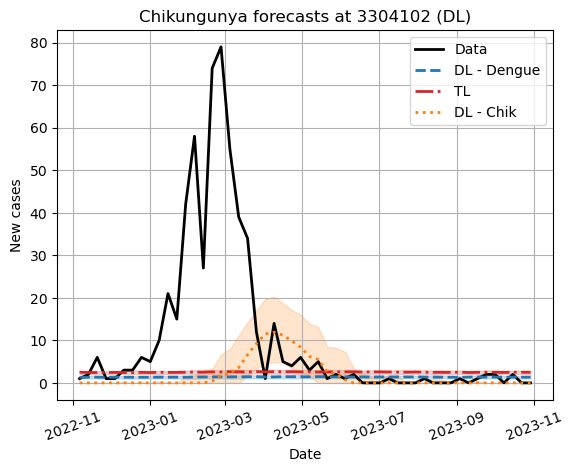

Skill score using RMSE
TL vs DL - dengue: 0.022683047470505202
TL vs DL - chik: 0.02152804373019912
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.004167253149046588
TL vs DL - chik: -0.03340179401049178


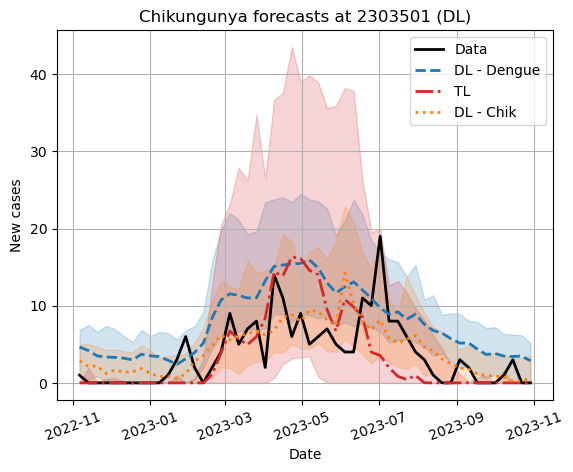

Skill score using RMSE
TL vs DL - dengue: 0.1628891210045622
TL vs DL - chik: -0.31069727837935734
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.3709998124435297
TL vs DL - chik: -0.23698602530733598


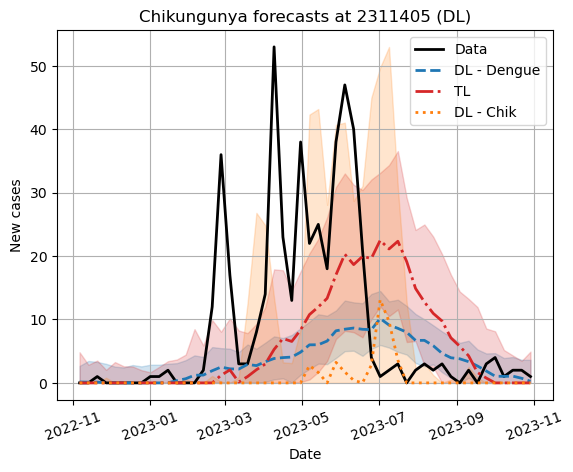

Skill score using RMSE
TL vs DL - dengue: 0.035530619450819145
TL vs DL - chik: 0.17109345724622382
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.04063545815272469
TL vs DL - chik: 0.08036490644559881


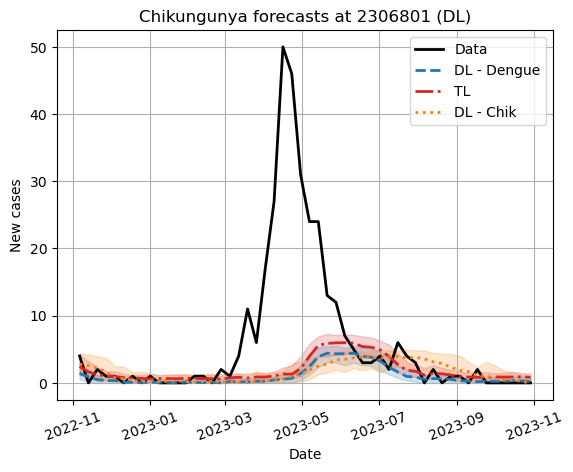

Skill score using RMSE
TL vs DL - dengue: 0.02913940101101886
TL vs DL - chik: 0.03541669615945753
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.04602938183270834
TL vs DL - chik: 0.05175853875641291


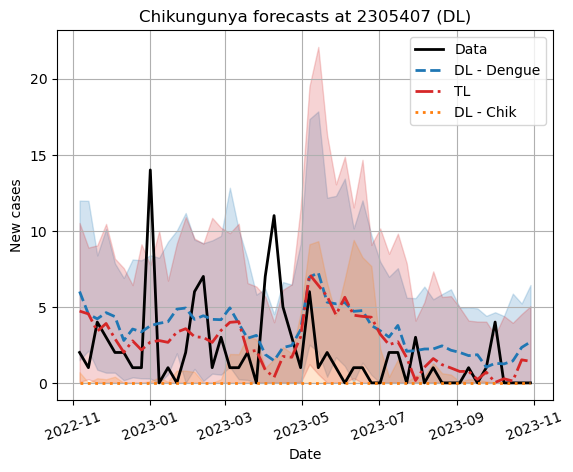

Skill score using RMSE
TL vs DL - dengue: 0.027760124571709732
TL vs DL - chik: 0.04415842845197404
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.11822432589018636
TL vs DL - chik: 0.10128336607125141


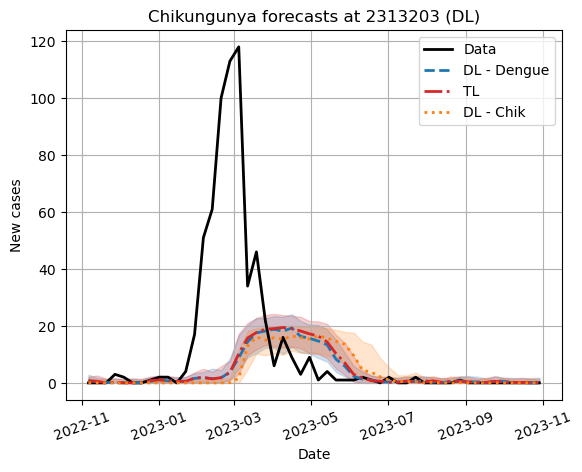

Skill score using RMSE
TL vs DL - dengue: 0.001720931949351301
TL vs DL - chik: 0.04344804247890266
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.01146775586870649
TL vs DL - chik: 0.06574247325598814


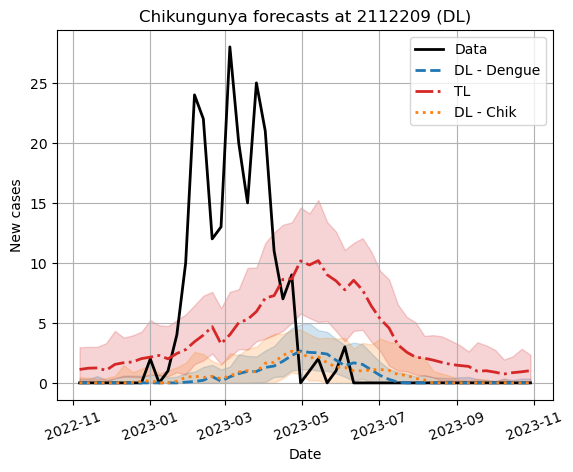

Skill score using RMSE
TL vs DL - dengue: 0.1104410965311794
TL vs DL - chik: 0.10009259829686179
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.08099833467842452
TL vs DL - chik: -0.11339289016846038


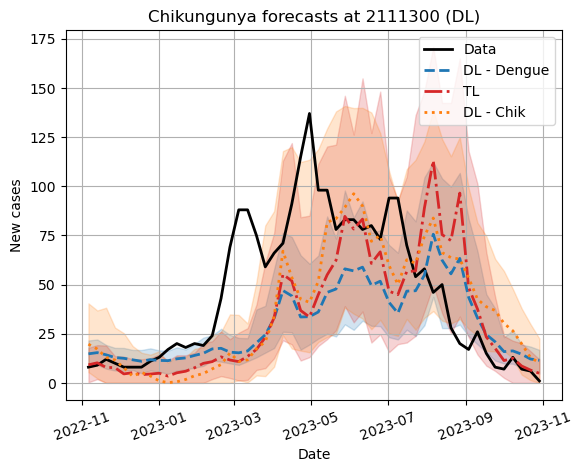

Skill score using RMSE
TL vs DL - dengue: -0.03678681774502368
TL vs DL - chik: -0.10278909953000404
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.03412738321078035
TL vs DL - chik: -0.04808766102796756


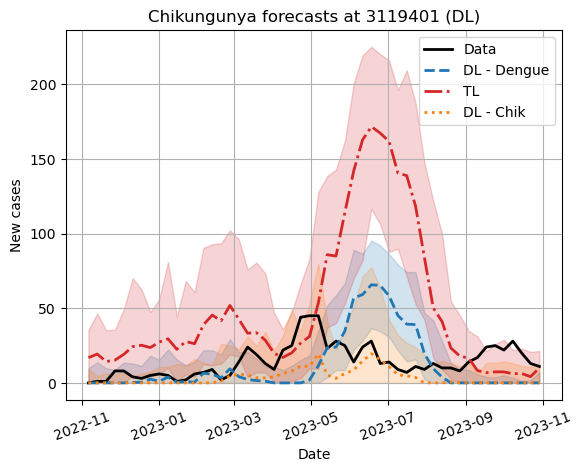

Skill score using RMSE
TL vs DL - dengue: -1.798631733605124
TL vs DL - chik: -3.2480025971609594
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -1.4989744916949845
TL vs DL - chik: -3.044218864186166


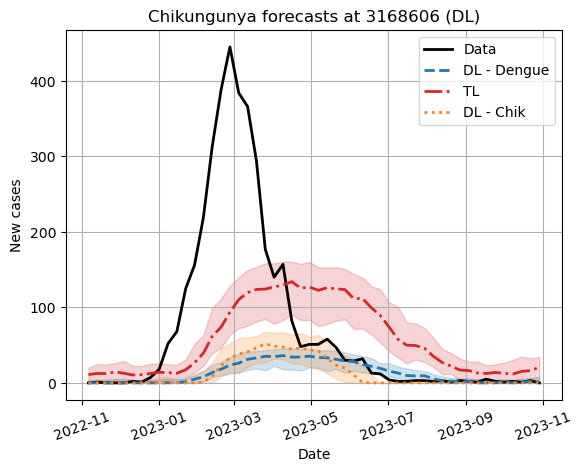

Skill score using RMSE
TL vs DL - dengue: 0.15867636335382151
TL vs DL - chik: 0.14074960727255925
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.02118441652221249
TL vs DL - chik: -0.050385374348878326


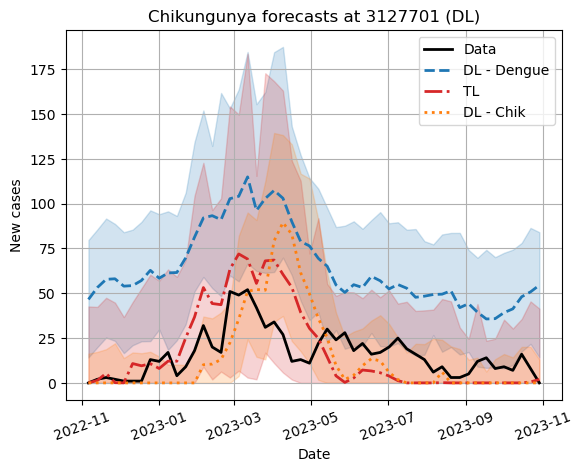

Skill score using RMSE
TL vs DL - dengue: 0.6609916542121781
TL vs DL - chik: 0.17313137754168284
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.7651115586082915
TL vs DL - chik: 0.11617231263830582


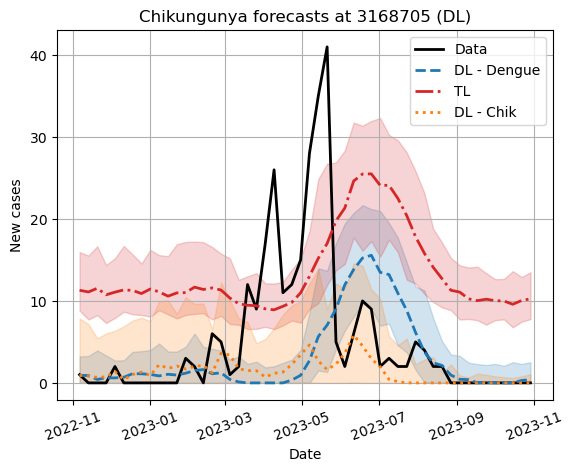

Skill score using RMSE
TL vs DL - dengue: -0.2904187481697942
TL vs DL - chik: -0.32576173639941675
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -1.1016888197321402
TL vs DL - chik: -1.5791947076994386


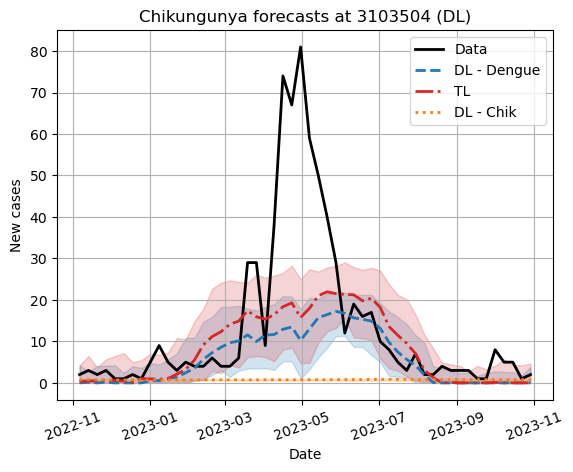

Skill score using RMSE
TL vs DL - dengue: 0.09567790831654199
TL vs DL - chik: 0.29803451881142473
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.0855334914060744
TL vs DL - chik: 0.41469069706146633


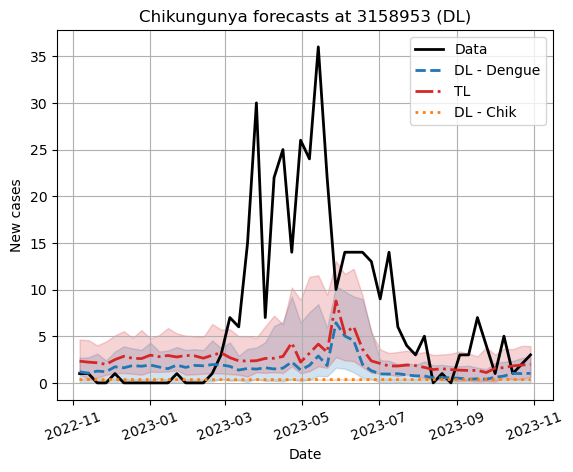

Skill score using RMSE
TL vs DL - dengue: 0.05602290032208057
TL vs DL - chik: 0.13178342199999504
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.060852091499540045
TL vs DL - chik: 0.20993120290158582


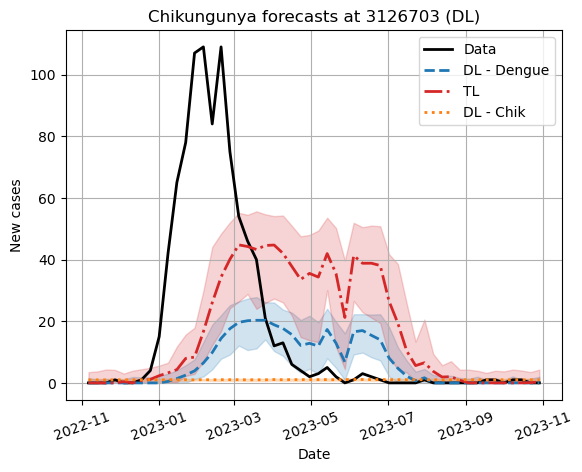

Skill score using RMSE
TL vs DL - dengue: -0.005829925215680154
TL vs DL - chik: 0.08573833761511462
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.19047935159848708
TL vs DL - chik: -0.08621241819371592


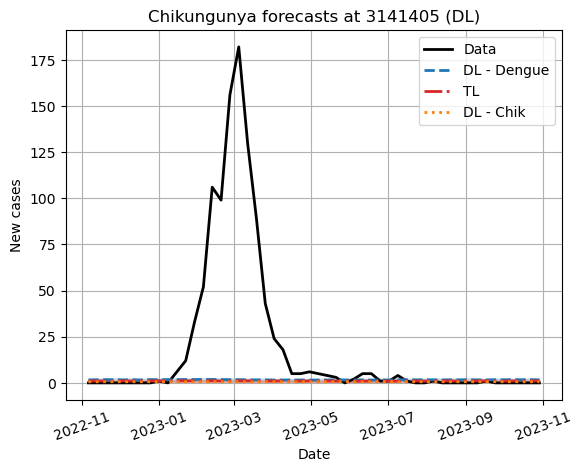

Skill score using RMSE
TL vs DL - dengue: -0.005640118448133835
TL vs DL - chik: 0.004214735475614462
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.001288170358005452
TL vs DL - chik: 0.008510229157185962


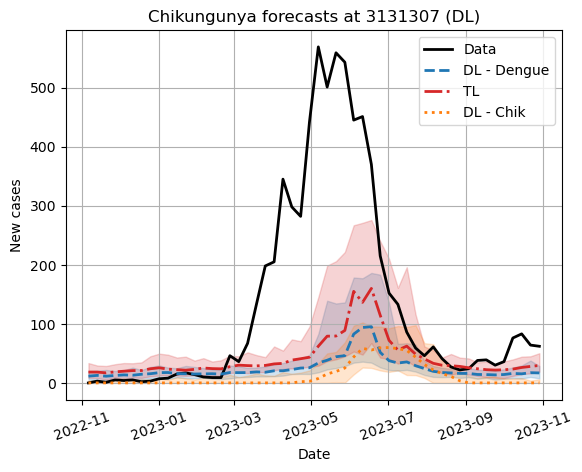

Skill score using RMSE
TL vs DL - dengue: 0.09104495461453332
TL vs DL - chik: 0.14667235529885514
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.14120418651039124
TL vs DL - chik: 0.2208589686398744


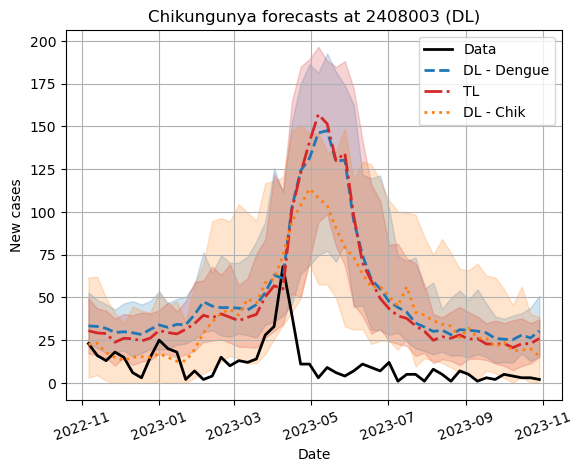

Skill score using RMSE
TL vs DL - dengue: 0.0052314024514859
TL vs DL - chik: -0.2689540265909267
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.09021556145426424
TL vs DL - chik: -0.22316161396163228


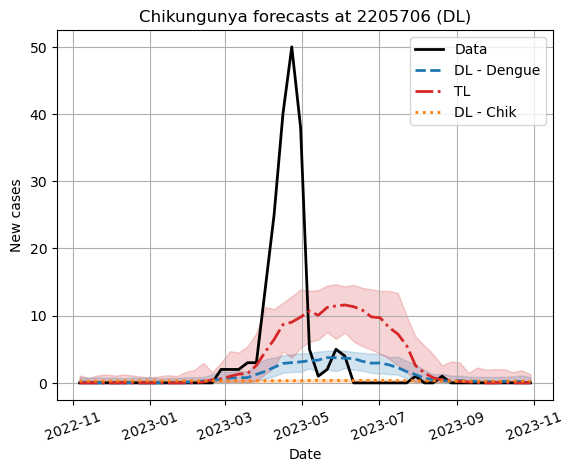

Skill score using RMSE
TL vs DL - dengue: 0.07145550625445174
TL vs DL - chik: 0.13134289939214705
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.16521186052073572
TL vs DL - chik: -0.07046331991772495


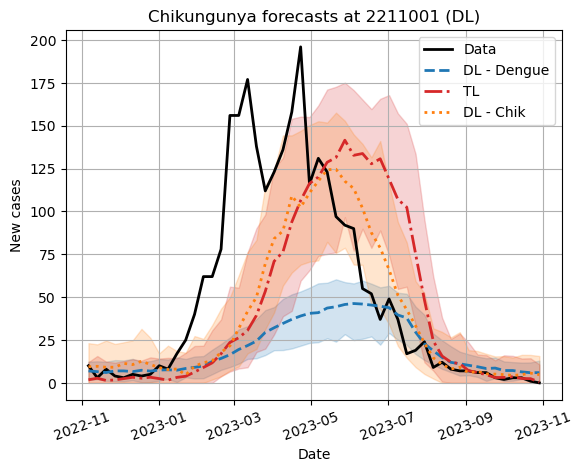

Skill score using RMSE
TL vs DL - dengue: 0.09539578868517107
TL vs DL - chik: -0.2371786192512213
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.12176529965420028
TL vs DL - chik: -0.3779167680575043


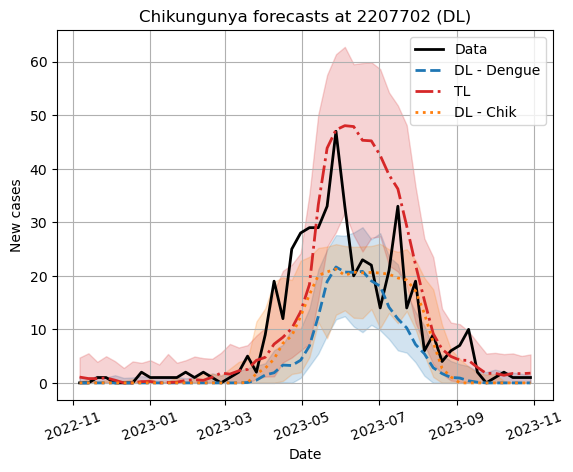

Skill score using RMSE
TL vs DL - dengue: -0.03538380861164314
TL vs DL - chik: -0.32405634801310446
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.13350863470685465
TL vs DL - chik: -0.14268920215904224


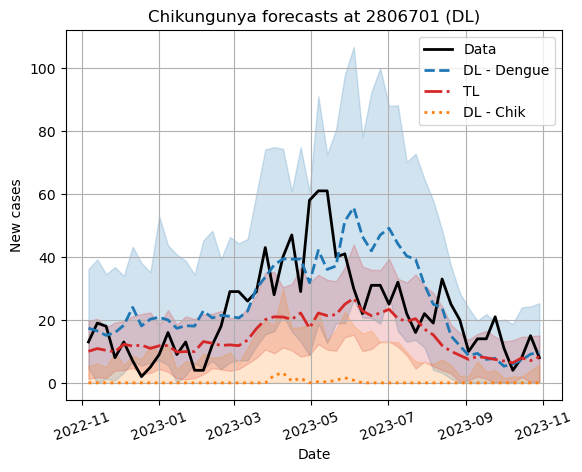

Skill score using RMSE
TL vs DL - dengue: -0.11310404007952912
TL vs DL - chik: 0.4759688543939057
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.1140498404124075
TL vs DL - chik: 0.602979638524467


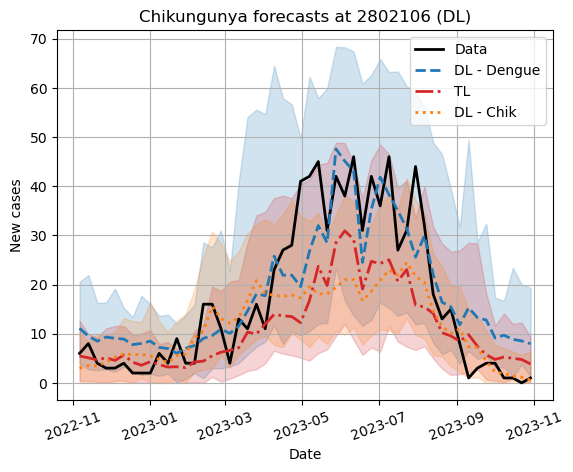

Skill score using RMSE
TL vs DL - dengue: -0.4401747462646104
TL vs DL - chik: 0.032290087933537825
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.19287318049445198
TL vs DL - chik: 0.08296949219331999


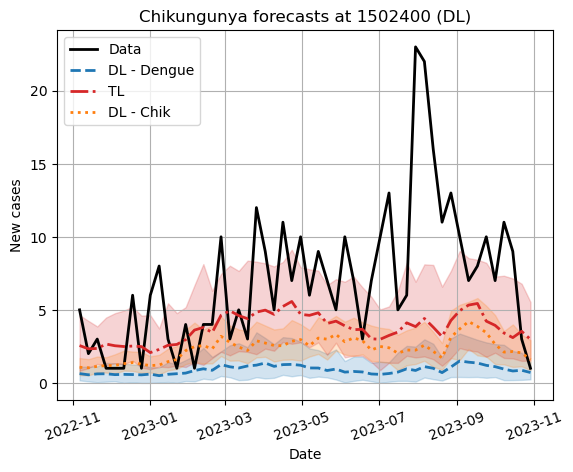

Skill score using RMSE
TL vs DL - dengue: 0.2745794184270538
TL vs DL - chik: 0.14392671159961856
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.4373318992942575
TL vs DL - chik: 0.271794173143588


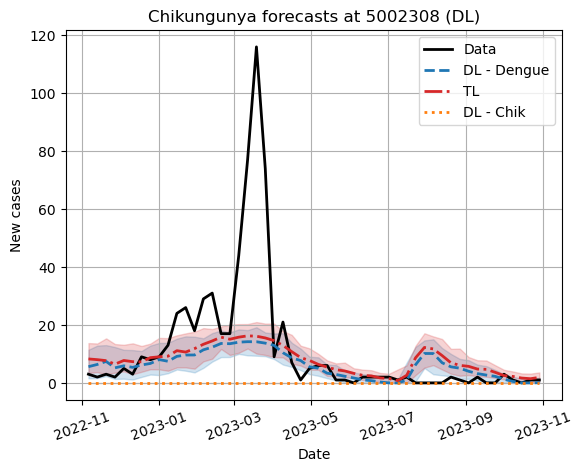

Skill score using RMSE
TL vs DL - dengue: 0.023054883983160912
TL vs DL - chik: 0.2125567151320258
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.02084078037518915
TL vs DL - chik: 0.30235215831385615


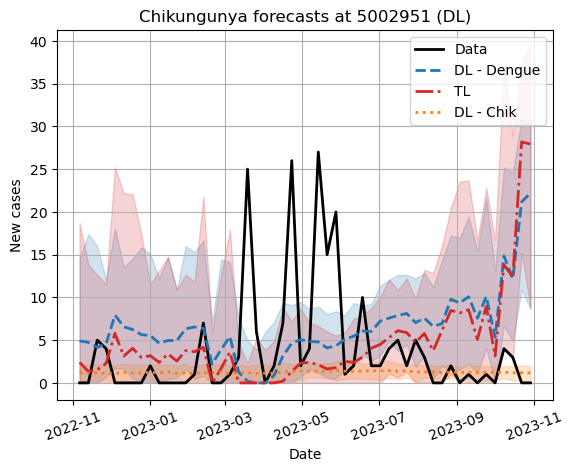

Skill score using RMSE
TL vs DL - dengue: -0.06459815196946161
TL vs DL - chik: -0.3453564099197237
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.13418090912133018
TL vs DL - chik: -0.3184359622380142


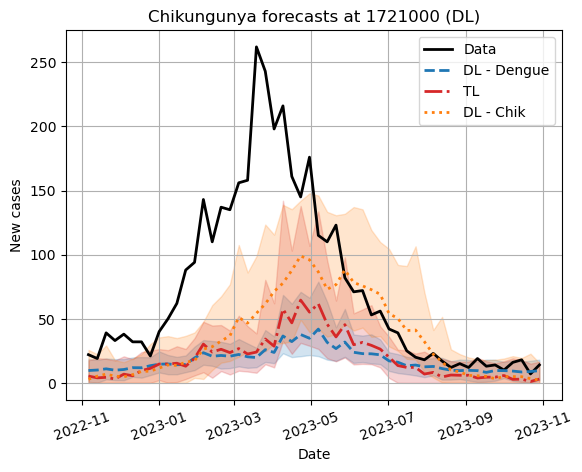

Skill score using RMSE
TL vs DL - dengue: 0.05893258098725451
TL vs DL - chik: -0.19932287410622251
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.09848643426214176
TL vs DL - chik: -0.2903558135627397


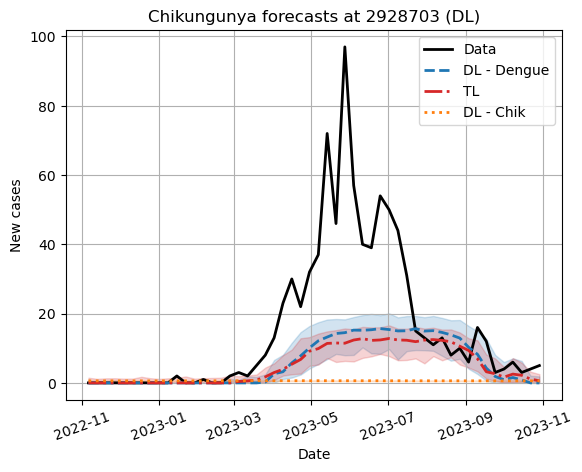

Skill score using RMSE
TL vs DL - dengue: -0.052713586464028905
TL vs DL - chik: 0.2052302669026025
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.0523176762618877
TL vs DL - chik: 0.3209818906586949


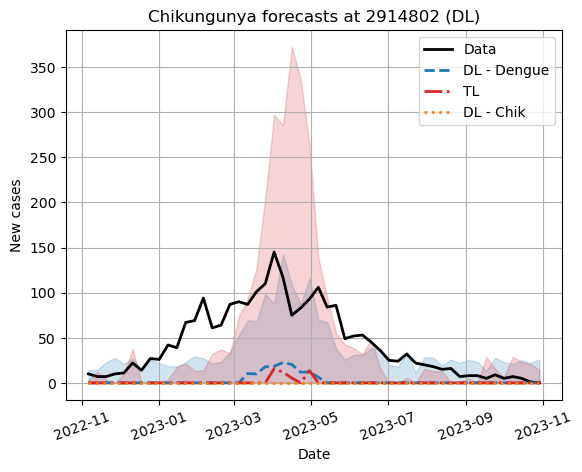

Skill score using RMSE
TL vs DL - dengue: -0.048208770529667655
TL vs DL - chik: 0.02940416442066396
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.016761581832371766
TL vs DL - chik: 0.21130375559084486


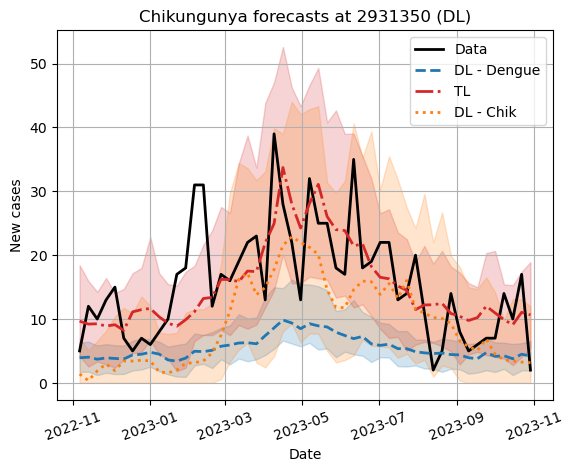

Skill score using RMSE
TL vs DL - dengue: 0.4569457981159022
TL vs DL - chik: 0.29496893235368904
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.5947336981747969
TL vs DL - chik: 0.3314534331059837


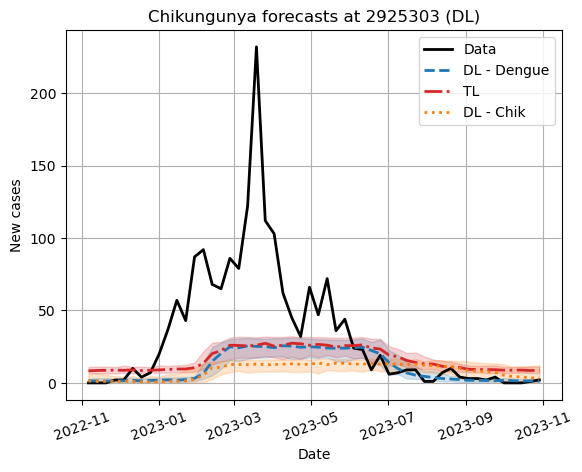

Skill score using RMSE
TL vs DL - dengue: 0.02644009428766858
TL vs DL - chik: 0.12024851940939396
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.037645144629220875
TL vs DL - chik: 0.13150707445646623


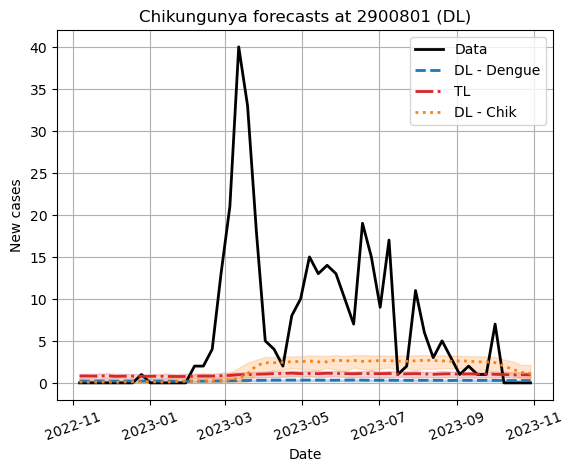

Skill score using RMSE
TL vs DL - dengue: 0.04014644509890197
TL vs DL - chik: -0.04208677179700682
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.05907126745204434
TL vs DL - chik: -0.12327657151384924


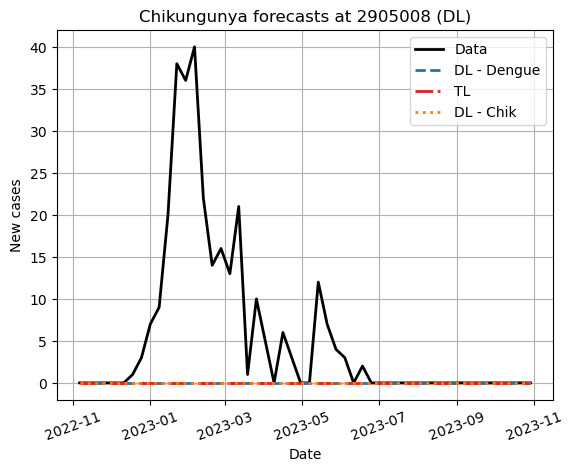

Skill score using RMSE
TL vs DL - dengue: 0.0
TL vs DL - chik: 0.0
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 1.7641568465438644e-08
TL vs DL - chik: -4.095437897040525e-09


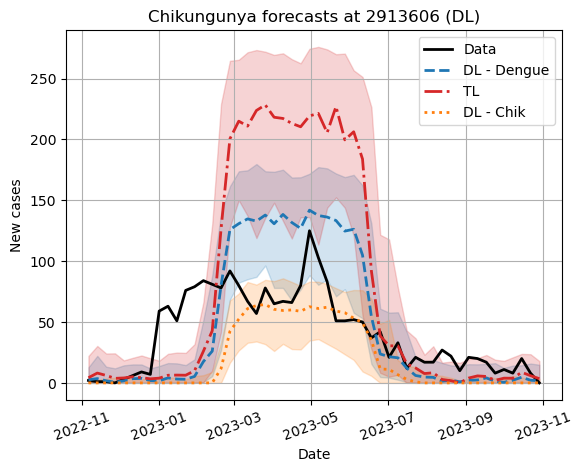

Skill score using RMSE
TL vs DL - dengue: -0.9725379738450544
TL vs DL - chik: -1.4878990947550856
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.8651505622490803
TL vs DL - chik: -1.22053844139939


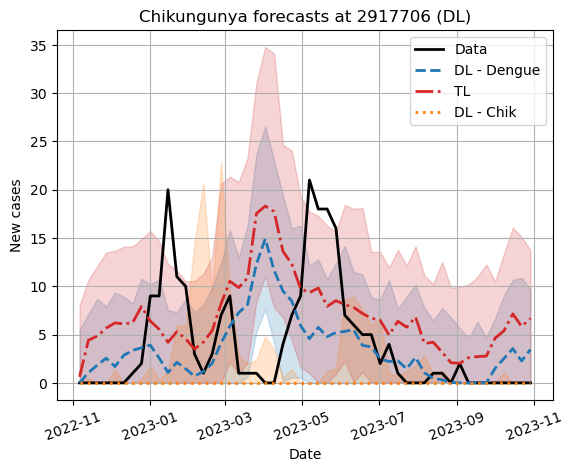

Skill score using RMSE
TL vs DL - dengue: -0.11682081472831607
TL vs DL - chik: 0.013183804782196273
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.259333927314236
TL vs DL - chik: -0.042378512516978245


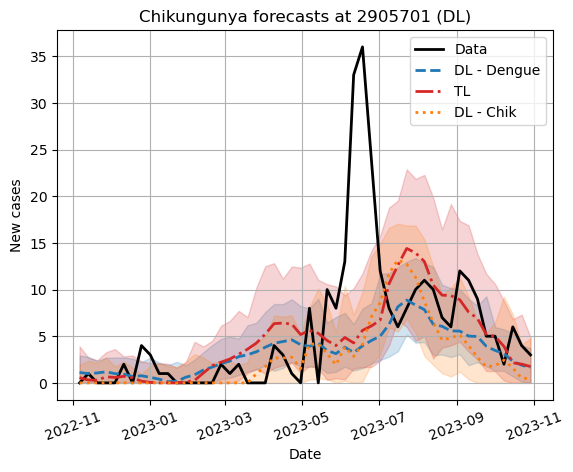

Skill score using RMSE
TL vs DL - dengue: 0.03488797253753673
TL vs DL - chik: 0.03575872316379258
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.04120090778917348
TL vs DL - chik: 0.01693888397159445


In [33]:
for city in df.geocode:
    plot_comp(city, ini_evaluate = ini_evaluate, end_evaluate = end_evaluate, model = 'DL')

In [34]:
df.head()

,geocode,muni_name,year,peak_week,beta,gamma,R0,total_cases,alpha,sum_res,ep_ini,ep_end,ep_dur,uf,state,n_last_ep,year_first_ep,year_last_ep_before_2023,start_train_chik,end_train_chik
30,3304102,Porciúncula,2023,7.409684,0.744030,0.302994,2.455592,510.374892,0.592766,0.747429,202302,202316,14,33,RJ,3,2016,2020,2015-10-01,2020-11-01
8,2303501,Cascavel,2023,21.031014,0.447854,0.300026,1.492714,196.791047,0.330079,1.124154,202302,202339,37,23,CE,3,2017,2022,2016-10-01,2022-11-01
86,2311405,Quixeramobim,2023,18.372554,0.533369,0.303351,1.758256,466.403595,0.431255,0.930381,202302,202332,30,23,CE,3,2016,2022,2015-10-01,2022-11-01
88,2306801,Jaguaribara,2023,16.407407,0.744166,0.309970,2.400772,302.644966,0.583467,1.126158,202309,202325,16,23,CE,1,2017,2017,2016-10-01,2017-11-01
122,2305407,Icó,2023,13.682026,0.429828,0.300005,1.432734,87.125102,0.302034,1.434513,202302,202334,32,23,CE,2,2017,2022,2016-10-01,2022-11-01


## New qq plot (only DL models by now):

In [35]:
def gen_data_to_qq(city, ini_evaluate,end_evaluate):
    
    df_end = pd.DataFrame()
    
    df = get_chik_data(city, ini_date = ini_evaluate,
                             end_date = end_evaluate)


    df_end['dates'] = df.index
    df_end['dates'] = pd.to_datetime(df_end['dates'])
    df_end['week'] = [Week.fromdate(i).weektuple()[1] for i in df_end['dates']] 
    df_end['target_chik'] = df['target'].values
    df_end['preds_dl_dengue'] =  df['preds_dengue_model'].values
    
    df_end['preds_tl'] =  df['preds_chik_model'].values

    df_end['preds_dl_chik'] = df['preds_chik_model'].values
    
    # adicionando os dados de dengue: 
    
    df_dengue = pd.read_csv(f'../data/dengue_{city}_cluster.csv', index_col = 'Unnamed: 0' , usecols = ['Unnamed: 0', f'casos_{city}'])
    
    
    df_dengue.index = pd.to_datetime(df_dengue.index)
    
    df_dengue['week'] = [Week.fromdate(i).weektuple()[1] for i in df_dengue.index] 
    
    df_dengue['year'] = [Week.fromdate(i).weektuple()[0] for i in df_dengue.index]
    
    #adicionando data faltando 
    
    v = ( df_dengue.loc['2018-04-01'][f'casos_{city}'] + df_dengue.loc['2018-04-15'][f'casos_{city}'] )/2
    
    f = {f'casos_{city}':v, 'week':15 , 'year':2018}
    
    
    s = pd.DataFrame(f, index=['2018-04-08'])
    
    # df_dengue = df_dengue.append(s)
    df_dengue = pd.concat([df_dengue, s], axis=0)
 
    df_dengue.index = pd.to_datetime(df_dengue.index)
    
    df_dengue = df_dengue.sort_index()
    
    
    for y in np.arange(2010, max(df_end.dates.dt.year)):
        
        df_s = df_dengue.loc[df_dengue.year == y]
        
        try:

            df_end[f'dengue_{y}'] = df_s.loc[ df_s.week.isin(df_end.week)][f'casos_{city}'].values
            
        except:
                        
            print('Erro para o ano:')
            print(y)
    


    
    return df_end

In [36]:
def plot_cross_qq(ax, q_o, q_p, title):
    sns.kdeplot(x = q_o[len(q_p) - len(q_o):], y = q_p, ax =ax, fill = True)
    ax.set_xlabel('observed')
    ax.set_ylabel('predicted')
    
    max_v = max( max(q_p), max(q_o))
    
    ax.set_xlim([0, max_v])
    ax.set_ylim([0, max_v])
    ax.plot([0, 100], [0, 100], 'k')
    
    ax.set_title(f'{title} - p.25: {round(np.percentile(q_p - q_o, 25),2)} - p.50: {round(np.median(q_p - q_o), 2)} - p.75: {round(np.percentile(q_p - q_o, 75), 2)}')
    #P.title(f'Transfer prediction percentiles with {model_name.lower()} for {doenca} at {city_name}')

def gen_qq_plot(city, ini_evaluate, end_evaluate, plot=True):
    
    df =  gen_data_to_qq(city, ini_evaluate, end_evaluate)
    
    cols = df.columns[ df.columns.str.startswith('dengue')]
    
    obs_preds = df[cols].values

    chik = df['target_chik'].values

    pred_tl = df['preds_tl'].values

    pred_dl_dengue = df['preds_dl_dengue'].values
    
    pred_dl_chik = df['preds_dl_chik'].values

    q_o = ss.percentileofscore(obs_preds, chik)

    q_p_dl_dengue = ss.percentileofscore(obs_preds, pred_dl_dengue)
    
    q_p_dl_chik = ss.percentileofscore(obs_preds, pred_dl_chik)

    q_p_tl = ss.percentileofscore(obs_preds, pred_tl)
    
    fig, ax = plt.subplots(1,3, figsize = (12,4))

    fig.suptitle(f'City - {city}', fontsize=12)
    
    plot_cross_qq(ax[0], q_o, q_p_tl, title = 'TL')

    plot_cross_qq(ax[1], q_o, q_p_dl_dengue, title = 'DL - dengue')
    
    plot_cross_qq(ax[2], q_o, q_p_dl_dengue, title = 'DL - chik')
    plt.tight_layout()
    
    plt.savefig(f'../figures/qq_plot_{city}.png', dpi = 300, bbox_inches = 'tight')
    
    
    if plot:
        plt.show()
    
    return


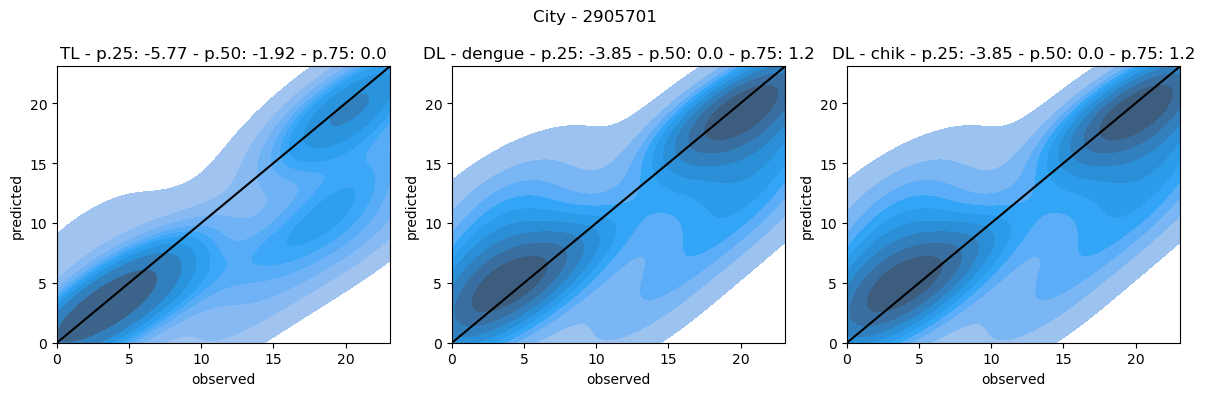

In [37]:
gen_qq_plot(city = city, ini_evaluate = ini_evaluate, end_evaluate = end_evaluate)

In [38]:
from pgbm.sklearn import HistGradientBoostingRegressor, crps_ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import numpy as np
X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
model = HistGradientBoostingRegressor(random_state=0).fit(X_train, y_train)  
yhat_point, yhat_point_std = model.predict(X_test, return_std=True)
yhat_dist = model.sample(yhat_point, yhat_point_std, n_estimates=1000, random_state=0)

In [39]:
yhat_dist.shape

(1000, 2064)

In [40]:
yhat_point.shape

(2064,)

In [41]:
np.percentile(yhat_dist, 0.025, axis=0).shape

(2064,)

In [42]:
end_date = '2023-11-01'
for city in df.geocode:
    plot_comp(city, ini_evaluate = ini_evaluate, end_evaluate = end_evaluate, model = 'DL', plot = False)
    plot_comp(city, ini_evaluate = ini_evaluate, end_evaluate = end_evaluate, model = 'PGBM', plot = False)
    gen_qq_plot(city, ini_evaluate = ini_evaluate, end_evaluate = end_evaluate, plot=False)

Skill score using RMSE
TL vs DL - dengue: 0.022683047470505202
TL vs DL - chik: 0.02152804373019912
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.004167253149046588
TL vs DL - chik: -0.03340179401049178


FileNotFoundError: [Errno 2] No such file or directory: '../predictions/pgbm/pgbm_3304102_chik_cross_pred.pkl'